In [1]:
%load_ext autoreload
%autoreload 2
import terra
import numpy as np
import seaborn as sns
from domino.evaluate import run_sdm, score_sdms

import matplotlib.pyplot as plt
from meerkat.contrib.imagenet import *

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [6]:
from domino.evaluate import run_sdm, score_sdms
score_df = score_sdms.out().load()

config_df = []
for run_id in score_df["run_sdm_run_id"].unique():
    inp = run_sdm.inp(run_id)
    config_df.append({
        "run_sdm_run_id": run_id, 
        "sdm_class": str(inp["sdm_class"]),
        "weight_y_log_likelihood": inp["sdm_config"].get("weight_y_log_likelihood", np.nan),
        "learning_rate": inp["sdm_config"].get("learning_rate", np.nan),
    })
config_df = pd.DataFrame(config_df)
df = score_df.merge(config_df, on="run_sdm_run_id")

In [8]:
settings_df = df.iloc[df.reset_index().groupby(["target_synset", "slice", "slice_idx", "sdm_class"])['precision_at_10'].idxmax().astype(int)]
print((settings_df["precision_at_10"] > 0.5).mean())
settings_df[["precision_at_10", "sdm_class", "target_synset", "slice", "run_sdm_run_id"]]

0.5555555555555556


,precision_at_10,sdm_class,target_synset,slice,run_sdm_run_id
46,0.4,<class 'domino.sdm.gmm.MixtureModelSDM'>,building.n.01,barn.n.01,12648
96,0.5,<class 'domino.sdm.gmm.MixtureModelSDM'>,building.n.01,mosque.n.01,12658
23,0.9,<class 'domino.sdm.gmm.MixtureModelSDM'>,dog.n.01,boxer.n.04,12643
87,0.6,<class 'domino.sdm.gmm.MixtureModelSDM'>,fish.n.01,ray.n.07,12656
36,0.3,<class 'domino.sdm.gmm.MixtureModelSDM'>,food.n.01,bread.n.01,12646
74,0.5,<class 'domino.sdm.gmm.MixtureModelSDM'>,food.n.01,course.n.07,12653
5,0.6,<class 'domino.sdm.gmm.MixtureModelSDM'>,fruit.n.01,berry.n.01,12640
62,0.9,<class 'domino.sdm.gmm.MixtureModelSDM'>,vehicle.n.01,bicycle.n.01,12651
50,0.7,<class 'domino.sdm.gmm.MixtureModelSDM'>,vehicle.n.01,truck.n.01,12649


In [3]:
settings_df = df.iloc[df.reset_index().groupby(["target_synset", "slice", "slice_idx", "sdm_class"])['precision_at_10'].idxmax().astype(int)]
print((settings_df["precision_at_10"] > 0.5).mean())
settings_df[["precision_at_10", "sdm_class", "target_synset", "slice", "run_sdm_run_id"]].groupby("sdm_class").mean()

0.7222222222222222


,precision_at_10,run_sdm_run_id
sdm_class,,
<class 'domino.sdm.gmm.MixtureModelSDM'>,0.566667,12607.888889
<class 'domino.sdm.spotlight.SpotlightSDM'>,0.755556,12622.555556


In [4]:
inp = run_sdm.inp(run_id=12602, load=True)
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

data_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[["image_id", "emb"]], on="image_id"
)

In [54]:
from domino.sdm import MixtureModelSDM, SpotlightSDM
sdm = MixtureModelSDM(
    n_slices=5, 
    n_clusters=25, 
    weight_y_log_likelihood=10, 
    init_params="error",
    emb="emb",
    pca_components=128 
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

 56%|█████▌    | 56/100 [00:09<00:07,  6.15it/s]


In [5]:
from domino.sdm import MixtureModelSDM, SpotlightSDM, GeorgeSDM
sdm = GeorgeSDM(
    n_slices=5, 
    #n_clusters=25, 
    emb="emb",
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

fitting umap
fitting umap done
fitting umap
fitting umap done


KeyboardInterrupt: 

In [10]:
from domino.metrics import compute_sdm_metrics
slice_idx = 0

metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(by="auroc", ascending=False)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
3,3,0,0.880256,0.1,0.08,0.05,0.0,0.0,0.0,1.0,0.031588
2,2,0,0.767497,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000
4,4,0,0.500000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000
0,0,0,0.149812,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000
1,1,0,0.149812,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000


In [57]:
from domino.emb.clip import embed_words
pred_slice_idx = 3
words_dp = embed_words.out(5143).load().lz[:int(1.1e4)]
expl_dp = sdm.explain(words_dp=words_dp, data_dp=data_dp)
expl_dp.lz[(-expl_dp["pred_slices"][:, pred_slice_idx]).argsort()[:10]]

KeyError: 'Column `pred_slices` does not exist.'

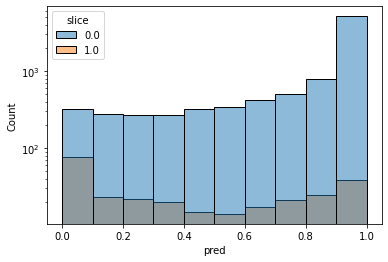

In [48]:
plot_df = pd.DataFrame(
    {"pred": dp["pred"], "slice": dp["slices"][:, slice_idx], "target": dp["target"]}
)
sns.histplot(
    data=plot_df[plot_df["target"] == 1],
    x="pred",
    hue="slice",
    stat="count",
    common_norm=not False,
    binwidth=0.1,
)
plt.yscale("log")


In [53]:
plot_df[(plot_df["pred"] < 0.2) & (plot_df["target"] == 1)].slice.mean()

0.14184397163120568

,image_id (PandasSeriesColumn),path (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),name (PandasSeriesColumn),synset_pos_offset (PandasSeriesColumn),synset (PandasSeriesColumn),target (NumpyArrayColumn),slices (NumpyArrayColumn),input (ImageColumn),id (PandasSeriesColumn),pred (NumpyArrayColumn),split (PandasSeriesColumn),emb (NumpyArrayColumn),pred_slices (NumpyArrayColumn)
0,n07695742_3446,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07695742/n07695742_3446.JPEG,1193700,,pretzel,n07695742,pretzel.n.01,1,"np.ndarray(shape=(1,))",,n07695742_3446,0.322086,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
1,n07695742_1668,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07695742/n07695742_1668.JPEG,1193428,,pretzel,n07695742,pretzel.n.01,1,"np.ndarray(shape=(1,))",,n07695742_1668,0.346772,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
2,n07693725_5358,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07693725/n07693725_5358.JPEG,1192694,,"bagel, beigel",n07693725,bagel.n.01,1,"np.ndarray(shape=(1,))",,n07693725_5358,0.358830,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
3,n07695742_7737,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07695742/n07695742_7737.JPEG,1194107,,pretzel,n07695742,pretzel.n.01,1,"np.ndarray(shape=(1,))",,n07695742_7737,0.051134,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
4,n07684084_2825,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07684084/n07684084_2825.JPEG,1190963,,French loaf,n07684084,french_loaf.n.01,1,"np.ndarray(shape=(1,))",,n07684084_2825,0.064168,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
5,n07693725_8860,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07693725/n07693725_8860.JPEG,1192972,,"bagel, beigel",n07693725,bagel.n.01,1,"np.ndarray(shape=(1,))",,n07693725_8860,0.203652,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
6,n07693725_7582,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07693725/n07693725_7582.JPEG,1192847,,"bagel, beigel",n07693725,bagel.n.01,1,"np.ndarray(shape=(1,))",,n07693725_7582,0.000730,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
7,n07693725_13139,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07693725/n07693725_13139.JPEG,1192093,,"bagel, beigel",n07693725,bagel.n.01,1,"np.ndarray(shape=(1,))",,n07693725_13139,0.000003,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
8,n07695742_7301,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07695742/n07695742_7301.JPEG,1194075,,pretzel,n07695742,pretzel.n.01,1,"np.ndarray(shape=(1,))",,n07695742_7301,0.269932,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
9,n07693725_9711,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07693725/n07693725_9711.JPEG,1193084,,"bagel, beigel",n07693725,bagel.n.01,1,"np.ndarray(shape=(1,))",,n07693725_9711,0.020270,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"

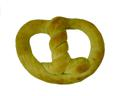
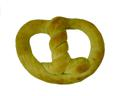
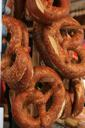
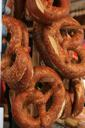
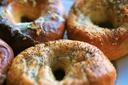
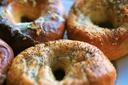
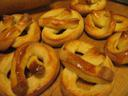
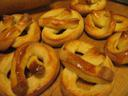
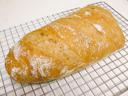
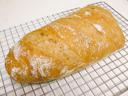
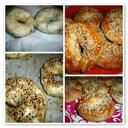
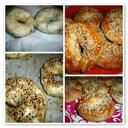
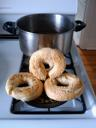
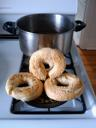
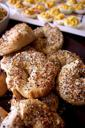
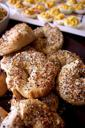
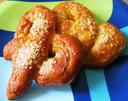
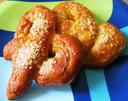
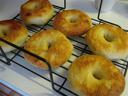
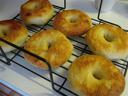

In [59]:

dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-10:]]#[["object_image", "target", "slice"]]

In [1]:
import ray.tune as tune

In [2]:
tune.sample_from(lambda spec: spec)

In [3]:
tune.grid_search([1,2,3])

{'grid_search': [1, 2, 3]}

In [19]:
common_config = {
    "n_slices": 5,
    "emb": tune.grid_search([("clip", "emb"), ("bit", "emb")]),
}

from ray.tune.suggest.variant_generator import _generate_variants

In [20]:
out = list(_generate_variants(
    {
        "sdm_class": MixtureModelSDM,
        "sdm_config": {
            "learning_rate": tune.grid_search([1e-2, 1e-3]),
            **common_config,
        },
    },
))

In [24]:
list(zip(*out))[1]

({'sdm_class': domino.sdm.gmm.MixtureModelSDM,
  'sdm_config': {'learning_rate': 0.01,
   'n_slices': 5,
   'emb': ('clip', 'emb')}},
 {'sdm_class': domino.sdm.gmm.MixtureModelSDM,
  'sdm_config': {'learning_rate': 0.01, 'n_slices': 5, 'emb': ('bit', 'emb')}},
 {'sdm_class': domino.sdm.gmm.MixtureModelSDM,
  'sdm_config': {'learning_rate': 0.001,
   'n_slices': 5,
   'emb': ('clip', 'emb')}},
 {'sdm_class': domino.sdm.gmm.MixtureModelSDM,
  'sdm_config': {'learning_rate': 0.001,
   'n_slices': 5,
   'emb': ('bit', 'emb')}})

In [1]:
import ray.cloudpickle as cloudpickle

In [ ]:
cloudpickle.